# BirdCLEF 2023 - Baseline Training

As a first baseline model we fine-tune an EfficientNet neural network on the prepared dB scaled mel power specturm images. 

The images have been prepared with [BC23 - Image Creation 128 x 256](https://www.kaggle.com/code/morodertobias/bc23-image-creation-128-x-256). Note these images might be suboptimal, but they should serve as a first start.

In [3]:
!pip install keras-cv

  Using cached keras_cv-0.4.2-py3-none-any.whl (634 kB)
  Using cached tensorflow_datasets-4.9.2-py3-none-any.whl (5.4 MB)
  Using cached promise-2.3-py3-none-any.whl
  Using cached etils-1.2.0-py3-none-any.whl (120 kB)
  Using cached tensorflow_metadata-1.13.1-py3-none-any.whl (28 kB)
  Using cached array_record-0.2.0-py39-none-any.whl (3.0 MB)
  Using cached importlib_resources-5.12.0-py3-none-any.whl (36 kB)
  Using cached googleapis_common_protos-1.59.0-py2.py3-none-any.whl (223 kB)


In [13]:
import os, pathlib
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from datetime import datetime
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydantic import BaseModel as ConfigBaseModel
import tensorflow as tf
import keras_cv
import tensorflow_io as tfio
from sklearn.model_selection import train_test_split

In [14]:
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of replicas: 1


# 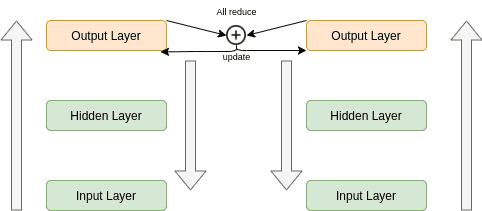

В TensorFlow эта стратегия называется «mirrored strategy» (стратегия, использующая зеркалирование), поддерживается два типа этой стратегии.

Стратегия tf.distribute.MirroredStrategy предназначена для организации обучения на нескольких ускорителях в пределах одного и того же воркера

In [15]:
sorted(tf.config.list_logical_devices())

[LogicalDevice(name='/device:CPU:0', device_type='CPU')]

# Config
гиперпараметры

In [20]:
class Config(ConfigBaseModel):
    ## general
    run_ts = datetime.now().strftime("%H:%M:%S")
    model_name = "net"
    test_size = 0.2
    seed = 887
    fit_verbose = 1 if (os.environ.get('KAGGLE_KERNEL_RUN_TYPE') == "Interactive") else 2
    ## data
    ## надо вставаить свой путь до файлов ??????????????????????????????????????????????????????????
    dataset_dir = "/kaggle/input/ds-bc23-image-creation-128-x-256/train/"
    path_data = "/kaggle/input/ds-bc23-image-creation-128-x-256/img_stats.csv"
    label = "label"
    n_label = 264
    img_size = (128, 256)
    channels = 1
    img_shape = (*img_size, channels)
    ## model
    base_model_weights = "imagenet"
    dropout = 0.20
    ## training
    label_smoothing = 0.05
    shuffle_size = 1028
    steps_per_epoch = 300
    batch_size = 128  # 16 * strategy.num_replicas_in_sync
    valid_batch_size = batch_size
    epochs = 30
    patience = 4
    monitor = "val_loss"  # val_loss
    monitor_mode = "auto"
    lr = 1e-3
    
    
    
cfg = Config()
#with open("cfg.json", "w") as f:
#    f.write(cfg.json(indent=2))
#cfg.dict()    

# Preparation

## Load data

In [17]:
data = pd.read_csv(cfg.path_data)
data["path_img"] = cfg.dataset_dir + data["filename"]
if cfg.debug:
    data = data.iloc[:1000]
data

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/ds-bc23-image-creation-128-x-256/img_stats.csv'

## Dataset

In [7]:
AUTOTUNE = tf.data.AUTOTUNE


def show_img_stats(img):
    if isinstance(img, tf.Tensor):
        print((img.shape, img.dtype, img.numpy().min(), img.numpy().max()))
    elif isinstance(img, np.array):
        print((img.shape, img.dtype, img.min(), img.max()))
    else:
        print(f"unexpected type: {type(img)}")


def read_image(path_img):
    img_data = tf.io.read_file(path_img)
    img = tf.io.decode_jpeg(img_data, channels=cfg.channels)
    img = tf.reshape(img, cfg.img_shape)
    img = tf.cast(img, tf.float32)
    return img


def decode_label(label):
    return tf.one_hot(label, depth=cfg.n_label)

In [9]:
def create_dataset(data, include_label=True, repeat=False, shuffle=False, augment=False, prefetch=False, batch_size=None):
    slices = data["path_img"].values
    read_func = read_image
    if include_label:
        slices = slices, decode_label(data[cfg.label].values)
        read_func = lambda path_img, label: (read_image(path_img), label)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(read_func, num_parallel_calls=AUTOTUNE)
    if repeat: ds = ds.repeat()
    if shuffle: ds = ds.shuffle(buffer_size=cfg.shuffle_size)
    if batch_size: ds = ds.batch(batch_size)
    if prefetch: ds = ds.prefetch(AUTOTUNE)
    return ds

In [18]:
def create_training_dataset(data):
    return create_dataset(
        data,
        include_label=True,
        repeat=True,
        shuffle=True,
        augment=False,
        prefetch=True,
        batch_size=cfg.batch_size,
    )


def create_validation_dataset(data):
    return create_dataset(
        data,
        include_label=True,
        repeat=False,
        shuffle=False,
        augment=False,
        prefetch=True,
        batch_size=cfg.valid_batch_size,
    )

# check dataset

In [13]:
dev_data = data.sample(500)
dev_ds = create_training_dataset(dev_data)
dev_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 264), dtype=tf.float32, name=None))>

In [14]:
elem = next(iter(dev_ds.take(1)))
elem[1]

<tf.Tensor: shape=(128, 264), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 229.90543)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 249.56091)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 250.27676)
(TensorShape([128, 256, 1]), tf.float32, 1.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 223.57014)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 214.91249)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)


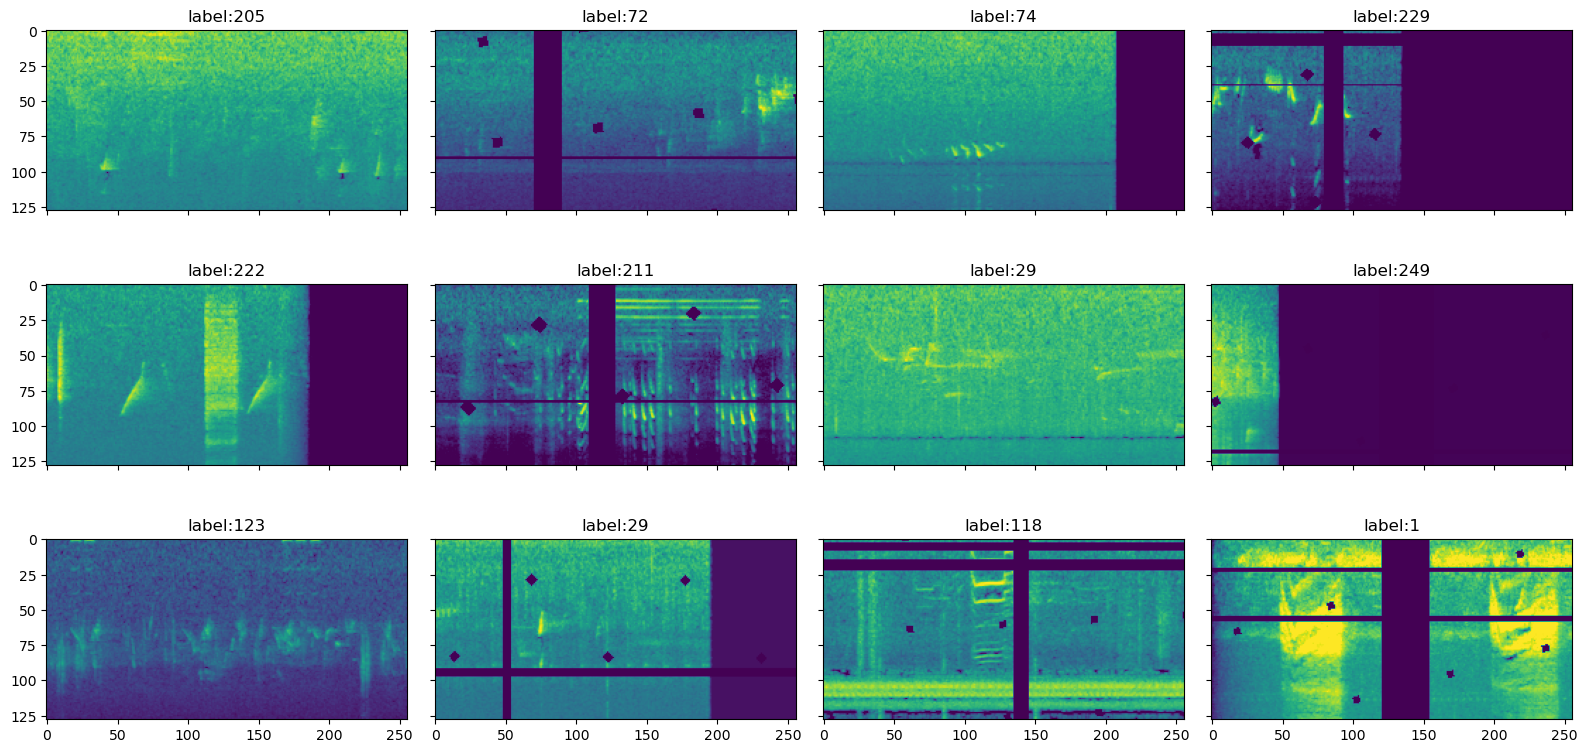

In [15]:
fig, axs = plt.subplots(3, 4, sharex='all', sharey='all', figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    img = elem[0][i]
    show_img_stats(img)
    ax.imshow(img, cmap="viridis")
    ax.set_title(f"label:{np.argmax(elem[1][i].numpy())}")
plt.tight_layout()
plt.show()

# Neural network

In [16]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0 as BaseModel
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, losses, metrics, callbacks

In [17]:
def create_model(lr):
    inputs = layers.Input(shape=cfg.img_shape, dtype=tf.float32)
    x = tf.image.grayscale_to_rgb(inputs)
    x = layers.Lambda(preprocess_input, name="preprocess_input")(x)
    base_model = BaseModel(include_top=False, weights=cfg.base_model_weights, pooling="avg")
    x = base_model(x, training=False)
    x = layers.Dropout(cfg.dropout, name="top_dropout")(x)
    outputs = layers.Dense(cfg.n_label, name="logits")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=cfg.model_name)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=cfg.label_smoothing),
        metrics=['acc']
    )
    return model

#### Check model

In [18]:
tf.keras.backend.clear_session()
with strategy.scope():
    dev_model = create_model(lr=cfg.lr)
dev_model.summary(line_length=120)

16705208/16705208 [==============================] - 2s 0us/step
Model: "dev-b0-v8"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_1 (InputLayer)                                 [(None, 128, 256, 1)]                           0                 
                                                                                                                        
 tf.image.grayscale_to_rgb (TFOpLambda)               (None, 128, 256, 3)                             0                 
                                                                                                                        
 preprocess_input (Lambda)                            (None, 128, 256, 3)                             0                 
                                                                     

In [19]:
dev_model.predict(dev_ds.take(1))

1/1 [==============================] - 5s 5s/step


array([[-0.5394179 , -0.13108492, -0.24272354, ...,  0.11380972,
        -0.19482005, -0.20546508],
       [ 0.05104765, -0.41208306, -0.5156035 , ...,  0.6707697 ,
        -0.6340631 , -0.96565044],
       [ 0.05746821, -0.84346867, -0.11468871, ...,  0.40443313,
        -1.0835161 ,  0.0443846 ],
       ...,
       [-0.18074651,  0.04133499, -0.547293  , ..., -0.01032004,
        -0.70937777, -0.6580136 ],
       [ 0.08750141, -0.31012428, -0.49478832, ...,  0.43208432,
        -0.8876346 , -0.5830907 ],
       [-0.18995336, -0.42897657, -0.35792238, ...,  0.03097427,
        -0.38777864, -1.0054432 ]], dtype=float32)

In [20]:
dev_model.evaluate(dev_ds.take(1), return_dict=True)

1/1 [==============================] - 7s 7s/step - loss: 0.7129 - acc: 0.0078


{'loss': 0.7128856778144836, 'acc': 0.0078125}

# Training utils

In [21]:
def get_callbacks(filepath):
    cbs = [
        callbacks.ModelCheckpoint(
            filepath=filepath,
            monitor=cfg.monitor,
            mode=cfg.monitor_mode,
            verbose=1,
            save_best_only=True,
            save_weights_only=True            
        ),
        callbacks.EarlyStopping(
            monitor=cfg.monitor,
            mode=cfg.monitor_mode,
            verbose=1,
            patience=cfg.patience,
            restore_best_weights=False,
        ),
    ]
    return cbs


def show_history(history):
    history_frame = pd.DataFrame(history.history)
    history_frame.index = pd.RangeIndex(1, len(history_frame) + 1, name="epoch")
    display(history_frame.style\
        .highlight_min(color='lightgreen', subset=['val_loss'])\
        .highlight_max(color='lightgreen', subset=['val_acc'])
    )
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=ax[0], title='loss')
    history_frame.loc[:, ['acc', 'val_acc']].plot(ax=ax[1], title='acc')
    plt.tight_layout()
    plt.show()
    
    
def compute_oof(model, valid_df):
    """Compute OOF"""
    valid_ds = create_validation_dataset(valid_df)
    oof_pred = model.predict(valid_ds, verbose=False)
    oof_pred = pd.DataFrame(tf.nn.sigmoid(oof_pred).numpy(), index=valid_df.index)
    oof = pd.concat({"y_true": valid_df[cfg.label], "y_pred": oof_pred}, axis=1)
    return oof    

In [22]:
def run_training(train_df, valid_df, model_name):
    # prepare dataset
    train_ds = create_training_dataset(train_df)
    valid_ds = create_validation_dataset(valid_df)
    # create model
    tf.keras.backend.clear_session()
    with strategy.scope():
        model = create_model(lr=cfg.lr)
    # fit
    steps_per_epoch = cfg.steps_per_epoch
    print("steps_per_epoch:", steps_per_epoch)
    path_weight = f"/kaggle/working/weights_{model_name}.h5"
    print("path_weights:", path_weight)
    hist = model.fit(
        train_ds,
        epochs=cfg.epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_ds,
        callbacks=get_callbacks(path_weight),
        verbose=cfg.fit_verbose
    )
    model.load_weights(path_weight)
    oof = compute_oof(model, valid_df)
    return hist, oof

# Run training
Let us start by training just a single split.

In [23]:
train_df, valid_df = train_test_split(data, test_size=cfg.test_size, stratify=data[cfg.label])
print(f"Split: {len(train_df)} vs {len(valid_df)}")
model_name = f"{cfg.model_name}"
print(f"model_name: {model_name}")

Split: 99592 vs 24898
model_name: dev-b0-v8


In [24]:
hist, oof = run_training(train_df, valid_df, model_name)

steps_per_epoch: 300
path_weights: /kaggle/working/weights_dev-b0-v8.h5
Epoch 1/30

Epoch 1: val_loss improved from inf to 0.12931, saving model to /kaggle/working/weights_dev-b0-v8.h5
300/300 - 417s - loss: 0.1363 - acc: 0.0496 - val_loss: 0.1293 - val_acc: 0.0476 - 417s/epoch - 1s/step
Epoch 2/30

Epoch 2: val_loss improved from 0.12931 to 0.12824, saving model to /kaggle/working/weights_dev-b0-v8.h5
300/300 - 344s - loss: 0.1293 - acc: 0.0849 - val_loss: 0.1282 - val_acc: 0.1713 - 344s/epoch - 1s/step
Epoch 3/30

Epoch 3: val_loss improved from 0.12824 to 0.12613, saving model to /kaggle/working/weights_dev-b0-v8.h5
300/300 - 339s - loss: 0.1276 - acc: 0.2554 - val_loss: 0.1261 - val_acc: 0.3437 - 339s/epoch - 1s/step
Epoch 4/30

Epoch 4: val_loss improved from 0.12613 to 0.12497, saving model to /kaggle/working/weights_dev-b0-v8.h5
300/300 - 317s - loss: 0.1260 - acc: 0.3838 - val_loss: 0.1250 - val_acc: 0.4432 - 317s/epoch - 1s/step
Epoch 5/30

Epoch 5: val_loss improved from 0.12

,loss,acc,val_loss,val_acc
epoch,,,,
1,0.136323,0.049557,0.129311,0.047594
2,0.129332,0.084922,0.128236,0.171339
3,0.127575,0.255391,0.126125,0.343682
4,0.126003,0.383802,0.124970,0.443208
5,0.125151,0.454375,0.124259,0.506065
6,0.124500,0.506536,0.123793,0.537714
7,0.123954,0.548047,0.123504,0.561732
8,0.123669,0.567734,0.123027,0.596072
9,0.123225,0.600365,0.122736,0.616274


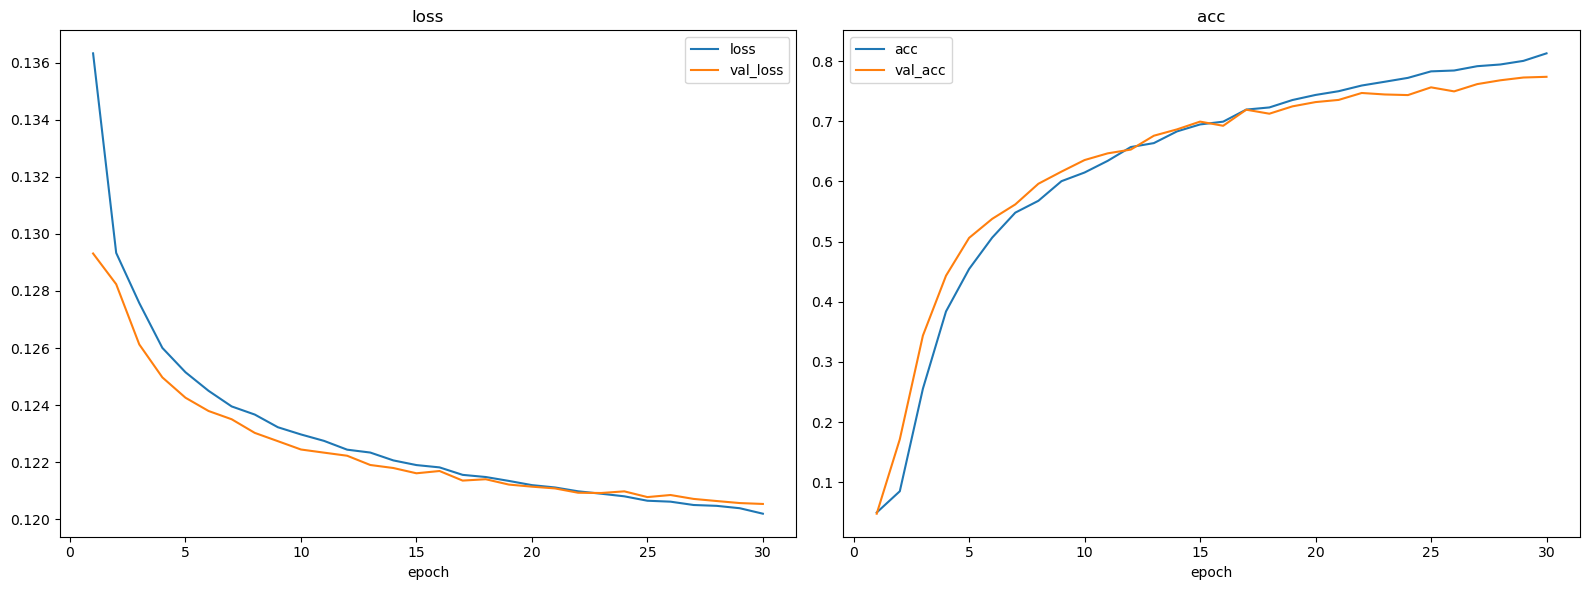

In [25]:
show_history(hist)

In [26]:
oof.to_csv("oof.csv")